<a href="https://colab.research.google.com/github/garaujo94/tcc-bi-master/blob/master/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projeto Nadir
Início do desenvolvimento do meu projeto de conclusão de curso que será chamado de projeto Nadir.<br>
Os objetivos que quero atingir são:


1.   Criar uma Rede Neural capaz de classificar imagens de constelações
2.   Criar uma Rede Neural capaz de classificar dentro de uma imagem do céu a localização e classificação de diversas constelações
3.   Criar uma Rede Neural capaz de segmentar a imagem e mostrar as constelações indicando os pontos das estrelas e os trações que formam os desenhos da constelações

Inicialmente, trabalharei com apenas 4 constelações:
1. Órion
2. Cruzeiro do Sul
3. Cão Maior
4. Ursa Menor

Tentarei alcançar os objetivos na ordem que foram descritos acima. Caso obtenha bons resultados, tentarei expandir o número de constelações.

Inicialmente, a fim de ver de ter um benchmark para o pré-processamento, farei os primeiros testes sem pré-processar as imagens do dataset.




In [ ]:
#%tensorflow_version 1.x

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import imutils
from imutils import paths
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

workdir_path = '/content/drive/My Drive/Colab Notebooks/TCC' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

 best.model   dataset  'Melhores modelos'   modelos   TCC2.ipynb   TCC.ipynb


## Definição de Funções de Apoio para o desenvolvimento do projeto

In [ ]:
dicionario = {
    0: 'canis major',
    1: 'crux',
    2: 'orion',
    3: 'ursa minor'
}

In [ ]:
#Testa 1 imagem já lida e pré-processada
def testImage(model, image, label_real, dicionario = dicionario):
    plt.imshow(image)
    plt.title(dicionario[np.argmax(label_real)])
    plt.xlabel("Prediction: " + (dicionario[np.argmax(model.predict(image.reshape(-1,224,224,3)))]))
    plt.show()

In [ ]:
#Testa um conjunto de 8 imagens simultaneamente
def gridImage8(model, image, label_real, inicio = 0, dicionario = dicionario):
  plt.figure(figsize=(25,10))
  for i in range(8):
    a = 240 + i + 1
    plt.subplot(int(a))
    plt.imshow(image[i + inicio])
    plt.title(dicionario[np.argmax(label_real[i + inicio])])
    plt.xlabel("Prediction: " + (dicionario[np.argmax(model.predict(image[i + inicio].reshape(-1,224,224,3)))]))

  plt.show()

In [ ]:
def matrix(labels, prediction):

  y = [np.argmax(ans) for ans in labels]
  pred = [np.argmax(ans) for ans in prediction]

  print(classification_report(y, pred))
  print('--------------------------------------')
  plt.figure(figsize=(5,5))
  plt.title('Matriz de Confusão')
  sns.heatmap(confusion_matrix(test_y, pred_y), annot=True, cbar=False, square=True)
  plt.show()

# Lendo os Dados

In [ ]:
train = '/content/drive/My Drive/Colab Notebooks/TCC/dataset/train/'
test = '/content/drive/My Drive/Colab Notebooks/TCC/dataset/test/'

Lendo as labels existentes e registrando

In [ ]:
labels = os.listdir(train)

In [ ]:
#Teste de código
labels[0]

'canis major'

In [ ]:
#Teste de código
for label in labels:
  print(label)
  print(os.listdir(train + label))

canis major
['1.jpg', '2.jpg', '3.jpg', '4.jpg']
crux
['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']
orion
['5.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg']
ursa minor
['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']


In [ ]:
#Teste de código
os.listdir(train +  labels[0])
list(paths.list_images(train +  labels[0]))

['/content/drive/My Drive/Colab Notebooks/TCC/dataset/train/canis major/1.jpg',
 '/content/drive/My Drive/Colab Notebooks/TCC/dataset/train/canis major/2.jpg',
 '/content/drive/My Drive/Colab Notebooks/TCC/dataset/train/canis major/3.jpg',
 '/content/drive/My Drive/Colab Notebooks/TCC/dataset/train/canis major/4.jpg']

Lendo os dados de treino e de teste e armazenando nas respectivas variáveis

In [ ]:
#Lendo os dados de treino
X_train = []
y_train = []
for label in labels:

  caminhos = list(paths.list_images(train +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    y_train.append(label)
    X_train.append(image)

In [ ]:
#Lendo os dados de teste
X_test = []
y_test = []
for label in labels:

  caminhos = list(paths.list_images(test +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    y_test.append(label)
    X_test.append(image)

Convertantendo para os formatos necessários

In [ ]:
X_train, y_train, X_test, y_test = np.array(X_train)/255.0, np.array(y_train), np.array(X_test)/255.0, np.array(y_test) 

canis major
--------------------------


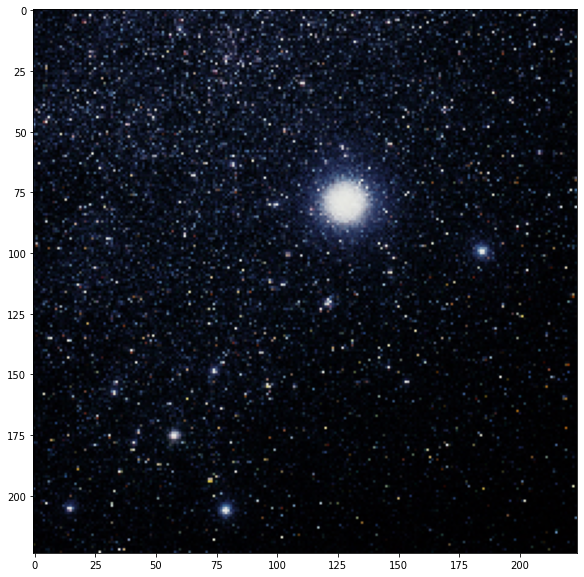

In [ ]:
#Checando se está tudo certo
print(y_train[0])
plt.figure(figsize=(10,10))
plt.imshow(X_train[0]);
print('--------------------------')

orion
--------------------------


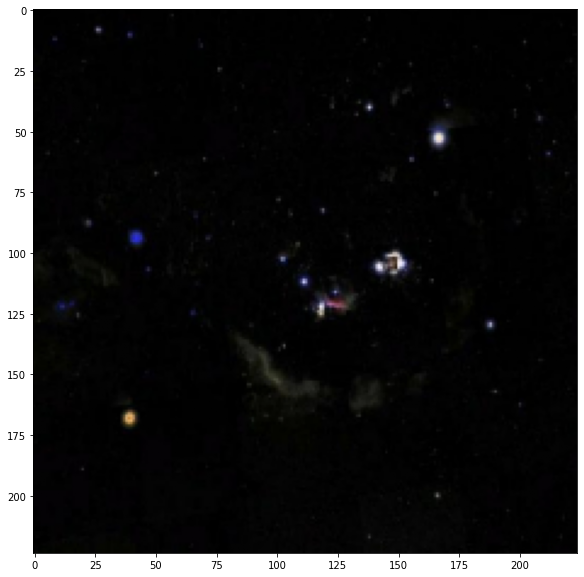

In [ ]:
print(y_test[5])
plt.figure(figsize=(10,10))
plt.imshow(X_test[5]);
print('--------------------------')

# Data Augmentation

Gerando o geradores de Data Augmentation. Estava dando algum erro que eu não identifiquei ainda. A imagem gerada ficava toda preta. Agora está funcionando, mas tomar cuidado pra ver se sempre está funcionando.

In [ ]:
#Data Augmentation
trainDataGen = ImageDataGenerator(
 rotation_range=30, zoom_range=0.2, width_shift_range=0.2, height_shift_range = 0.2,featurewise_center=True,
    featurewise_std_normalization=True, horizontal_flip=True
)

testDataGen = ImageDataGenerator(
 rotation_range=30, zoom_range=0.2, width_shift_range=0.2, height_shift_range = 0.2,featurewise_center=True,
    featurewise_std_normalization=True, horizontal_flip=True
)

In [ ]:
#trainDataGen.fit(X_train)
#testDataGen.fit(X_test)

In [ ]:
batch_size = 16

train_generator = trainDataGen.flow(X_train, np.array(pd.get_dummies(y_train)), 
                                     batch_size=batch_size, 
                                     shuffle=True)

test_generator = testDataGen.flow(X_test, np.array(pd.get_dummies(y_test)), 
                                     batch_size=batch_size, 
                                    shuffle=True)

In [ ]:
#Apenas um teste para ter certeza que o Data Augmentation funcionou
#i = 0
#for X_batch, y_batch in train_generator:
#  while i < 9:
#    plt.subplot(330+1+i)
#    plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
#    i += 1
#    if i >= 9:  break
#  plt.show()

Os generators vão retornar uma tupla: CORRIGIR
1. A primeira será a imagem em si. O valor de X
2. A segunda será o label relativo. O valor de y

In [ ]:
x, y = train_generator.__next__()

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
y[0]

array([0, 0, 1, 0], dtype=uint8)

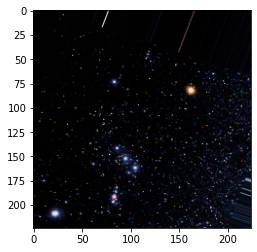

In [ ]:
plt.imshow(x[0])

In [ ]:
#print(train_generator.__next__()[1][1])
#plt.imshow(train_generator.__next__()[0][1]);

In [ ]:
X_train.shape[0]//batch_size + 1

2

In [ ]:
X_test.shape[0]//batch_size + 1

1

In [ ]:
train_steps_per_epoch = X_train.shape[0]//batch_size + 1
test_steps_per_epoch = X_test.shape[0]//batch_size + 1

increase_by=50
steps_per_epoch = train_steps_per_epoch*increase_by
train_features=[]
train_labels=[]
for i in range(steps_per_epoch):
    print("\rTraining Batches: {}/{}\n".format(i+1,steps_per_epoch), end="")
    x,y = train_generator.__next__()
    #x=preprocess_input(x)
    train_features.append(x)
    train_labels.append(y)
    print(steps_per_epoch)

test_features=[]
test_labels=[]
for i in range(test_steps_per_epoch*increase_by):
    print("\rTest Batches: {}/{}\n".format(i+1,test_steps_per_epoch), end="")
    x,y = test_generator.__next__()
    #x=preprocess_input(x)
    test_features.append(x)
    test_labels.append(y)
    print(steps_per_epoch)

train_features = np.concatenate(train_features,axis=0)
train_labels = np.concatenate(train_labels,axis=0)
test_features = np.concatenate(test_features,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

print('\nCreation of vectors image finished!')

Training Batches: 1/100
100
Training Batches: 2/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100
Training Batches: 3/100
100
Training Batches: 4/100
100
Training Batches: 5/100
100
Training Batches: 6/100
100
Training Batches: 7/100
100
Training Batches: 8/100
100
Training Batches: 9/100
100
Training Batches: 10/100
100
Training Batches: 11/100
100
Training Batches: 12/100
100
Training Batches: 13/100
100
Training Batches: 14/100
100
Training Batches: 15/100
100
Training Batches: 16/100
100
Training Batches: 17/100
100
Training Batches: 18/100
100
Training Batches: 19/100
100
Training Batches: 20/100
100
Training Batches: 21/100
100
Training Batches: 22/100
100
Training Batches: 23/100
100
Training Batches: 24/100
100
Training Batches: 25/100
100
Training Batches: 26/100
100
Training Batches: 27/100
100
Training Batches: 28/100
100
Training Batches: 29/100
100
Training Batches: 30/100
100
Training Batches: 31/100
100
Training Batches: 32/100
100
Training Batches: 33/100
100
Training Batches: 34/100
100
Training Batches: 35/100
100
Training Batches: 36/100
100
Training Batches:

In [ ]:
train_labels.shape

(950, 4)

In [ ]:
test_labels.shape

(400, 4)

In [ ]:
steps_per_epoch

100

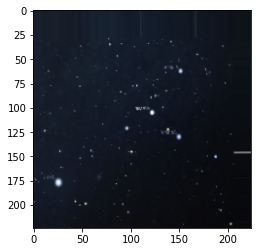

In [ ]:
plt.imshow(train_features[0])

# Montando o Modelo

Será usado Transfer Learning usando de base a rede VGG16

Abordagem fazendo a rede toda junta

In [ ]:
model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
a=Model(inputs=model_vgg.input,outputs=model_vgg.get_layer('block4_pool').output)
a.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
INIT_LR = 1e-3
EPOCHS = 1000 # PODE MUDAR
BS = 32

In [ ]:
headmodel = model_vgg.output
headmodel = Flatten(name="flatten")(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(64, activation='relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(4, activation='softmax')(headmodel)

model = Model(inputs = model_vgg.input, outputs = headmodel, name='Nadir')

for layer in model_vgg.layers:
  layer.trainable = False

opt = SGD(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)

model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "Nadir"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
callbacks = [
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
    ModelCheckpoint('best.model', save_best_only=True),
    EarlyStopping(patience=25, verbose=True)
]


In [ ]:
h = model.fit(
    train_features, train_labels,
    batch_size = 16,
    validation_split = 0.2,
    epochs = 1000,
    callbacks = callbacks
)

Epoch 1/1000
48/48 [==============================] - ETA: 0s - loss: 1.4642 - accuracy: 0.2803WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best.model/assets
48/48 [==============================] - 13s 277ms/step - loss: 1.4642 - accuracy: 0.2803 - val_loss: 1.3528 - val_accuracy: 0.3211
Epoch 2/1000
48/48 [==============================] - 11s 219ms/step - loss: 1.3780 - accuracy: 0.2737 - val_loss: 1.3453 - val_accuracy: 0.3316
Epoch 3/1000
48/48 [==============================] - 8s 161ms/step - loss: 1.3573 - accuracy: 0.3013 -

In [ ]:
#h = model.fit(
#    train_generator,
#    steps_per_epoch = 15,
#    validation_data = train_generator,
#    validation_steps = 5,
#    epochs = 50
#)

# Avaliação do primeiro modelo

In [ ]:
df_history = pd.DataFrame(h.history)

fig = plt.figure();
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5));
df_history['lr'].plot(ax=ax.twinx(), color='gray');

In [ ]:
fig = plt.figure();
ax = df_history[['val_accuracy', 'accuracy']].plot(figsize=(10, 5));

In [ ]:
df_history.tail()

In [ ]:
gridImage8(
    model,
    test_features,
    test_labels,
    inicio = 10
)

In [ ]:
testImage(
    model,
    test_features[0],
    test_labels[0]
)

In [ ]:
testImage(
    model,
    test_features[1],
    test_labels[1]
)

Na primeira Rodada:<br>Acc .8774<br>Val_acc 1.0<br><br>Com SGD:<br>Acc .9539<br>Val_acc 1.0

In [ ]:
np.max(df_history.accuracy)

In [ ]:
np.max(df_history.val_accuracy)

In [ ]:
pred = model.predict(test_features)

In [ ]:
matrix(test_labels, pred)

In [ ]:
dicionario

# Realizando pré-processamento

Testarei primeiramente tirar a cor da imagem e tentar suavizar as estrelas menos brilhantes, pois as estrelas que definem a constelação são as mais brilhantes das fotos

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(X_train[0])
plt.show()

In [ ]:
a = cv2.cvtColor(X_train[0], cv2.COLOR_RGB2GRAY)

In [ ]:
#Lendo os dados de treino
X_train_mod1 = []
y_train_mod1 = []
for label in labels:

  caminhos = list(paths.list_images(train +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (224, 224))


    y_train_mod1.append(label)
    X_train_mod1.append(image)

In [ ]:
#Lendo os dados de teste
X_test_mod1 = []
y_test_mod1 = []
for label in labels:

  caminhos = list(paths.list_images(test +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (224, 224))

    y_test_mod1.append(label)
    X_test_mod1.append(image)

In [ ]:
X_train_mod1, y_train_mod1, X_test_mod1, y_test_mod1 = np.array(X_train_mod1)/255.0, np.array(y_train_mod1), np.array(X_test_mod1)/255.0, np.array(y_test_mod1) 

In [ ]:
#image = cv2.cvtColor(X_train[0], cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(8,8))
plt.imshow(X_train_mod1[0])
plt.title('Imagem em preto e branco')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(X_test_mod1[0])
plt.title('Imagem em preto e branco')
plt.show()

In [ ]:
image.shape

In [ ]:
mask = cv2.erode(X_train_mod1[0], None, iterations = 1)
plt.figure(figsize=(8,8))
plt.imshow(mask)
plt.title('Imagem em preto e branco')
plt.show()

In [ ]:
mask = cv2.erode(X_test_mod1[0], None, iterations = 1)
plt.figure(figsize=(8,8))
plt.imshow(mask)
plt.title('Imagem em preto e branco')
plt.show()

In [ ]:
mask = cv2.erode(X_train_mod1[1], None, iterations = 1)
print(dicionario[np.argmax(y_train_mod1[1])])
print('-------------------------------')
plt.figure(figsize=(15,6))
plt.subplot(121)

plt.imshow(X_train_mod1[1])
plt.title('Original')

plt.subplot(122)

plt.imshow(mask)
plt.title('Imagem em preto e branco')
plt.show()

In [ ]:
d = cv2.erode(X_train_mod1[3], None, iterations = 1)
print(y_train_mod1[3])
print('-------------------------------')
plt.figure(figsize=(15,6))
plt.subplot(121)

plt.imshow(X_train_mod1[3])
plt.title('Original')

plt.subplot(122)

plt.imshow(d)
plt.title('Imagem em preto e branco')
plt.show()

Algo está dando errado, pois não está carregando com a erosão aplicada com o cv2.erode

In [ ]:
#Lendo os dados de treino
X_train_mod1 = []
y_train_mod1 = []
for label in labels:

  caminhos = list(paths.list_images(train +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (224, 224))
    image = cv2.erode(image, None, iterations = 1)

    y_train_mod1.append(label)
    X_train_mod1.append(image)
print(f'{len(y_train)} imagens carregadas')

In [ ]:
#Lendo os dados de teste
X_test_mod1 = []
y_test_mod1 = []
for label in labels:

  caminhos = list(paths.list_images(test +  label))

  for caminho in caminhos:
    image = cv2.imread(caminho)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (224, 224))
    image = cv2.erode(image, None, iterations = 1)

    y_test_mod1.append(label)
    X_test_mod1.append(image)
print(f'{len(y_test)} imagens carregadas')

In [ ]:
range(len(X_train_mod1))

In [ ]:

for i in range(len(X_train_mod1)):
  plt.imshow(X_train_mod1[i])
  plt.show()



In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(X_train_mod1[0])
plt.title('Imagem em preto e branco')
plt.show()

In [ ]:
#a = cv2.cvtColor(X_train_mod1[0], cv2.COLOR_RGB2GRAY)
edge = cv2.Canny(X_train_mod1[0], 30, 150) #30 e 150 são os valores mínimos e máximos de threshold
plt.imshow(edge)
plt.title('Imagem em preto e branco')
plt.show()

In [ ]:
X_train_mod1, y_train_mod1, X_test_mod1, y_test_mod1 = np.array(X_train_mod1)/255.0, np.array(y_train_mod1), np.array(X_test_mod1)/255.0, np.array(y_test_mod1) 

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(X_train_mod1[0])
plt.title('Imagem em preto e branco')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(X_test_mod1[0])
plt.title('Imagem em preto e branco')
plt.show()

# Data Augmentation

Gerando o geradores de Data Augmentation. Estava dando algum erro que eu não identifiquei ainda. A imagem gerada ficava toda preta. Agora está funcionando, mas tomar cuidado pra ver se sempre está funcionando.

In [ ]:
#Data Augmentation
trainDataGen = ImageDataGenerator(
 rotation_range=30, zoom_range=0.2, width_shift_range=0.2
)

testDataGen = ImageDataGenerator(
 rotation_range=30, zoom_range=0.2, width_shift_range=0.2
)

In [ ]:
batch_size = 16

train_generator = trainDataGen.flow(X_train_mod1.reshape(X_train_mod1.shape[0],224,224,1), np.array(pd.get_dummies(y_train_mod1)), 
                                     batch_size=batch_size, 
                                     shuffle=True)

test_generator = testDataGen.flow(X_test_mod1.reshape(X_test_mod1.shape[0],224,224,1), np.array(pd.get_dummies(y_test_mod1)), 
                                     batch_size=batch_size, 
                                    shuffle=True)

In [ ]:
#Apenas um teste para ter certeza que o Data Augmentation funcionou
#i = 0
#for X_batch, y_batch in train_generator:
#  while i < 9:
#    plt.subplot(330+1+i)
#    plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
#    i += 1
#    if i >= 9:  break
#  plt.show()

Os generators vão retornar uma tupla: CORRIGIR
1. A primeira será a imagem em si. O valor de X
2. A segunda será o label relativo. O valor de y

In [ ]:
x, y = train_generator.__next__()

In [ ]:
y[0]

In [ ]:
plt.imshow(x[0].reshape(224,224))

In [ ]:
plt.imshow(train_generator.__next__()[0][0].reshape(224,224))

In [ ]:
#print(train_generator.__next__()[1][1])
#plt.imshow(train_generator.__next__()[0][1]);

In [ ]:
X_train_mod1.shape[0]//batch_size + 1

In [ ]:
X_test_mod1.shape[0]//batch_size + 1

In [ ]:
train_steps_per_epoch = X_train_mod1.shape[0]//batch_size + 1
test_steps_per_epoch = X_test_mod1.shape[0]//batch_size + 1

increase_by=45
steps_per_epoch = train_steps_per_epoch*increase_by
train_features_mod1=[]
train_labels_mod1=[]
for i in range(steps_per_epoch):
    print("\rTraining Batches: {}/{}\n".format(i+1,steps_per_epoch), end="")
    x,y = train_generator.__next__()
    #x=preprocess_input(x)
    train_features_mod1.append(x)
    train_labels_mod1.append(y)
    print(steps_per_epoch)

test_features_mod1=[]
test_labels_mod1=[]
for i in range(test_steps_per_epoch*increase_by):
    print("\rTest Batches: {}/{}\n".format(i+1,test_steps_per_epoch), end="")
    x,y = test_generator.__next__()
    #x=preprocess_input(x)
    test_features_mod1.append(x)
    test_labels_mod1.append(y)
    print(steps_per_epoch)

train_features_mod1 = np.concatenate(train_features_mod1,axis=0)
train_labels_mod1 = np.concatenate(train_labels_mod1,axis=0)
test_features_mod1 = np.concatenate(test_features_mod1,axis=0)
test_labels_mod1 = np.concatenate(test_labels_mod1,axis=0)

print('\nCreation of vectors image finished!')

In [ ]:
train_labels_mod1.shape

In [ ]:
test_labels_mod1.shape

In [ ]:
steps_per_epoch

In [ ]:
plt.imshow(train_features_mod1[15].reshape(224,224))

In [ ]:
model_mod1 = Model(inputs = model_vgg.input, outputs = headmodel, name='Nadir2')

for layer in model_vgg.layers:
  layer.trainable = False

#opt = Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)

model_mod1.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

In [ ]:
callbacks = [
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
    ModelCheckpoint('best_mod1.model', save_best_only=True),
    EarlyStopping(patience=25, verbose=True)
]


In [ ]:
train_features_mod1.shape

In [ ]:
h_mod1 = model_mod1.fit(
    train_features_mod1, train_labels_mod1,
    batch_size = 16,
    validation_split = 0.2,
    epochs = 1000,
    callbacks = callbacks
)

In [ ]:
df_history_mod1 = pd.DataFrame(h_mod1.history)

fig = plt.figure();
ax = df_history_mod1[['val_loss', 'loss']].plot(figsize=(10, 5));
df_history_mod1['lr'].plot(ax=ax.twinx(), color='gray');

In [ ]:
fig = plt.figure();
ax = df_history_mod1[['val_accuracy', 'accuracy']].plot(figsize=(10, 5));

In [ ]:
df_history_mod1.tail()

In [ ]:
np.max(df_history_mod1.accuracy)

In [ ]:
np.max(df_history_mod1.val_accuracy)

Acc 0.7647<br>Val_acc 0.9803

In [ ]:
model_mod1.evaluate(test_features_mod1, test_labels_mod1, batch_size=16)

In [ ]:
model.evaluate(test_features, test_labels, batch_size=16)

In [ ]:
gridImage8(model,test_features,test_labels)

In [ ]:
gridImage8(model_mod1,test_features_mod1,test_labels_mod1)

In [ ]:
plt.imshow(test_features_mod1[0])

In [ ]:
pd.Series(y_train_mod1).value_counts()

In [ ]:
test_labels_mod1.sum()

In [ ]:
pd.DataFrame(test_labels_mod1)

In [ ]:
print('Canis Major:')
print(pd.DataFrame(test_labels_mod1)[0].sum())
print('--------------------')
print('Crux:')
print(pd.DataFrame(test_labels_mod1)[1].sum())
print('--------------------')
print('Orion:')
print(pd.DataFrame(test_labels_mod1)[2].sum())
print('--------------------')
print('Ursa Minor:')
print(pd.DataFrame(test_labels_mod1)[3].sum())
print('--------------------')

In [ ]:
dicionario